##Setting up+libraries

In [0]:
from operator import add
import csv
from matplotlib import pyplot as plt

##loading of data

In [0]:
##could be used to change between clinal files
Files_Clin='/FileStore/tables/clinicaltrial_2021.csv'
File_pharma='/FileStore/tables/pharma.csv'
File_mesh='/FileStore/tables/mesh.csv'

In [0]:
find_index=lambda x: x.rfind('/')
Floc_temp_clinc='file:/tmp' + Files_Clin[find_index(Files_Clin):]

In [0]:
#use to uplaod datas
try:
    dbutils.fs.ls(Files_Clin)
except Exception as e:
    dbutils.fs.cp(Floc_temp_clinc,Files_Clin)
else:
    print('==============================')
    print("Clinical file already uploaded")
    print('==============================')
    
print(' ')
print(' ')

try:
    dbutils.fs.ls(File_pharma)
except Exception as e:
    dbutils.fs.cp('file:/tmp/pharma.csv',File_pharma)
else:
    print('==============================')
    print("Pharma file already uploaded")
    print('==============================')
    
print(' ')
print(' ')

try:
    dbutils.fs.ls(File_mesh)
except Exception as e:
    dbutils.fs.cp('file:/tmp/mesh.csv',File_mesh)
else:
    print('==============================')
    print("Mesh file already uploaded")
    print('==============================')

Clinical file already uploaded
 
 
Pharma file already uploaded
 
 
Mesh file already uploaded


### Load Data

In [0]:
clinicaltrial_2021=sc.textFile(Files_Clin)
CL2021_header = clinicaltrial_2021.first()
clinicaltrial_2021=clinicaltrial_2021.filter(lambda z: z!=CL2021_header)\
.mapPartitions(lambda line: csv.reader(line, delimiter='|'))
clinicaltrial_2021.take(1)

Out[59]: [['NCT02758028',
  'The University of Hong Kong',
  'Recruiting',
  'Aug 2005',
  'Nov 2021',
  'Interventional',
  'Apr 2016',
  '',
  '']]

In [0]:
clinicaltrial_2021.map(lambda x:(x[2],x[4]))\
.filter(lambda x:x[1].endswith('2021'))\
.map(lambda x:(x[0],1))\
.reduceByKey(lambda x,y:x+y)\
.collect()

Out[60]: [('Recruiting', 12902),
 ('Active, not recruiting', 6127),
 ('Terminated', 803),
 ('Completed', 8571),
 ('Unknown status', 2289),
 ('Withdrawn', 753),
 ('Enrolling by invitation', 918),
 ('Suspended', 306),
 ('Not yet recruiting', 2958)]

In [0]:
pharma=sc.textFile(File_pharma)
pharma_head = pharma.first()
pharma=pharma.filter(lambda z: z!=pharma_head)\
.mapPartitions(lambda line: csv.reader(line, delimiter=','))
pharma.take(1)

Out[61]: [['Abbott Laboratories',
  'Abbott Laboratories',
  '$5,475,000',
  '$0',
  '$5,475,000',
  '2013',
  '20131227',
  'government-contracting-related offenses',
  'False Claims Act and related',
  'kickbacks and bribery',
  "Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company's carotid, biliary and peripheral vascular products.",
  'federal',
  'agency action',
  'Justice Department Civil Division',
  'civil',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'USA',
  'Illinois',
  'publicly traded',
  'ABT',
  'pharmaceuticals',
  'pharmaceuticals',
  'https://www.justice.gov/opa/pr/abbott-laboratories-pays-us-5475-million-settle-claims-company-paid-kickbacks-physicians',
  '']]

In [0]:
mesh=sc.textFile(File_mesh)
mesh_head = mesh.first()
mesh=mesh.filter(lambda z: z!=mesh_head)\
.mapPartitions(lambda line: csv.reader(line, delimiter=','))
mesh.take(3)

Out[62]: [['Calcimycin', 'D03.633.100.221.173'],
 ['A-23187', 'D03.633.100.221.173'],
 ['Temefos', 'D02.705.400.625.800']]

###Answer-question 1
The number of studies in the dataset

In [0]:
clinicaltrial_2021.count()

Out[63]: 387261

### Define helper function

In [0]:
def count_values(rdd, topN=None):
    """
    A function that counts the elemnts of an rdd and sort it in descending order
    
    Input:
    =====
    - rdd (rdd): the rdd of interest
    - topN (int, default = None): the number of elements to return
    
    Output:
    ======
    - value_counts (rdd): the counted and sorted rdd
    """
    
    value_counts=\
    rdd.filter(lambda x: x!='')\
    .map(lambda z: (z, 1))\
    .reduceByKey(add)\
    .map(lambda z: (z[1], z[0]))\
    .sortByKey(ascending=False)\
    .map(lambda z: (z[1], z[0]))
    
    if topN==None:
        return value_counts.collect()
    return value_counts.take(topN)

###Answer-question 2
list all the types and frequencies

In [0]:
Type=CL2021_header.split('|').index('Type')
types=clinicaltrial_2021.map(lambda col: col[Type])
count_values(types)

Out[65]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

###Answer-question 3
The top 5 conditions (from Conditions) with their frequencies

In [0]:
Conditions=CL2021_header.split('|').index('Conditions')

indCond=clinicaltrial_2021.map(lambda col: col[Conditions])\
.filter(lambda z: z!='')\
.flatMap(lambda z: z.split(','))

count_values(indCond, topN=5)

Out[66]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

d
###Answer-question 4
mapped each condition to one or more hierarchy codes.Shows the 5
most frequent roots after map
done.

In [0]:
RDD_Cli=\
indCond.map(lambda z: (z, 6)) ## 6 is a dummy value so that we can easily join
RDD_Cli.take(5)

Out[67]: [('Autistic Disorder', 6),
 ('Autism Spectrum Disorder', 6),
 ('Diabetes Mellitus', 6),
 ('Tuberculosis', 6),
 ('Lung Diseases', 6)]

In [0]:
RDD_mesh =mesh.map(lambda obs: tuple(obs))
RDD_mesh.take(5)

Out[68]: [('Calcimycin', 'D03.633.100.221.173'),
 ('A-23187', 'D03.633.100.221.173'),
 ('Temefos', 'D02.705.400.625.800'),
 ('Temefos', 'D02.705.539.345.800'),
 ('Temefos', 'D02.886.300.692.800')]

In [0]:
codes=\
RDD_Cli.join(RDD_mesh)\
.map(lambda z: z[1][1])\
.map(lambda z: z.split('.'))\
.map(lambda z: z[0])\

count_values(codes, topN=5)

Out[69]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310)]

###Answer-question 5
Find the 10 most common sponsors that are not pharmaceutical companies, along with the number
of clinical trials they have sponsored

In [0]:
pharma_head

Out[70]: '"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"'

In [0]:
Parent_Company=1
Sponsor=CL2021_header.split('|').index('Sponsor')

In [0]:
RDD_Spon = clinicaltrial_2021.map(lambda col: col[Sponsor])
RDD_Pharm = pharma.map(lambda col: col[Parent_Company])\
.map(lambda x: x.replace('"',''))\
.collect()

In [0]:
filt=RDD_Spon.filter(lambda z: z not in RDD_Pharm)
count_values(filt, topN=10)

Out[73]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

###Answer-question 6
Plot number of completed studies each month in a given year – for the submission dataset, the year
is 2021

In [0]:
Status=CL2021_header.split('|').index('Status')
Completion=CL2021_header.split('|').index('Completion')

In [0]:
def isnum(z):
    if not z.isnumeric():
        return z

Complted_monthly=\
clinicaltrial_2021.map(lambda col: tuple(col[z] for z in [Completion,Status]))\
.filter(lambda z: z[1] == 'Completed' and z[0] != '')\
.map(lambda z: tuple(z[0].split()))\
.filter(lambda z: z[1] == '2021')\
.flatMap(lambda z: z)\
.map(isnum)\
.filter(lambda z: z != None)

result=count_values(Complted_monthly)
result

Out[75]: [('Mar', 1227),
 ('Jan', 1131),
 ('Jun', 1094),
 ('May', 984),
 ('Apr', 967),
 ('Feb', 934),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [0]:
mydict={
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

def rearrange_months(rdd):
    new_list=[]
    for j in rdd:
        for q in mydict.items():
            if j[0] == q[1]:
                new_list.append((q[0], j))
    return sc.parallelize(new_list)

a=\
rearrange_months(result)\
.sortByKey(True)\
.map(lambda z: z[1])
a.collect()

Out[76]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [0]:
Month=a.map(lambda z:z[0]).collect()
Count=a.map(lambda z:z[1]).collect()

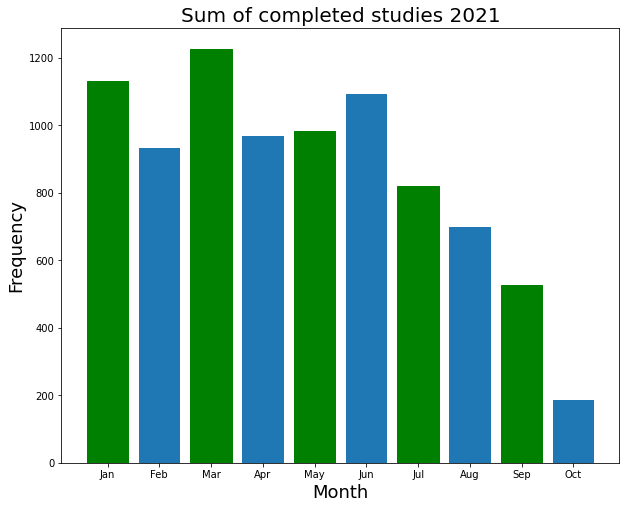

In [0]:
plt.figure(figsize=(10,8))
barplot=plt.bar(Month, Count)
barplot[0].set_color('green')
barplot[2].set_color('green')
barplot[4].set_color('green')
barplot[6].set_color('green')
barplot[8].set_color('green')
plt.xlabel('Month', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Sum of completed studies 2021', fontsize=20)
plt.show()

Further analysis

To understand the status of all the clinical trials for completion year '2021'

In [0]:
clinicaltrial_2021.map(lambda x:(x[2],x[4]))\
.filter(lambda x:x[1].endswith('2021'))\
.map(lambda x:(x[0],1))\
.reduceByKey(lambda x,y:x+y)\
.collect()

Out[79]: [('Recruiting', 12902),
 ('Active, not recruiting', 6127),
 ('Terminated', 803),
 ('Completed', 8571),
 ('Unknown status', 2289),
 ('Withdrawn', 753),
 ('Enrolling by invitation', 918),
 ('Suspended', 306),
 ('Not yet recruiting', 2958)]